In [1]:
import skimage
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import io
from skimage.draw import disk

In [2]:
np.random.seed(173)

In [3]:
def get_target_picture(name) :
    print("Target picture:")
    target_picture = io.imread(name)
    io.imshow(target_picture) 
    io.show()
    print("Shape: ", target_picture.shape)
    return target_picture

In [4]:
def put_image(board, image, position) :
    dx, dy = image.shape[0], image.shape[1]
    x, y = position[0], position[1]
    board[x:x + dx, y:y + dy, :] = image

In [5]:
def sim(img_a, img_b) :
    dif = img_a - img_b
    return np.sum(dif ** 2)

In [6]:
class tile() :
    
    color = (0, 0, 0)
    
    def init(self, col) :
        self.color = col
    
    def mutate_color(self, idx, shift) :
        self.color[idx] += np.random.randint(-shift, shift + 1)
        self.color = np.clip(self.color, 0, 255)
        
        

In [7]:
class individual() :
    
    N = 0
    size = 0
    tiles = []
    
    def init(self, _N, _size, tls) :
        self.N = _N
        self.size = _size
        self.tiles = tls
    
    def draw(self, tp) :
        X, Y = tp.shape[0], tp.shape[1]
        ret = np.zeros((X, Y, 3), dtype=int)
        pos_x = 0
        while(pos_x < X) :
            pos_y = 0
            while(pos_y < Y) :
                ret[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :] = copy.deepcopy(self.tiles[0].color)
                pos_y += self.size
            pos_x += self.size
        for i in range(1, self.N) :
            col = copy.deepcopy(self.tiles[i].color)
            pos_x = 0
            while(pos_x < X) :
                pos_y = 0
                while(pos_y < Y) :
                    prev_col = copy.deepcopy(ret[pos_x][pos_y])
                    prev_local_fitness = sim(ret[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :], tp[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :])
                    ret[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :] = col
                    cur_local_fitness = sim(ret[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :], tp[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :])
                    if(cur_local_fitness > prev_local_fitness) :
                        ret[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :] = prev_col
                    pos_y += self.size
                pos_x += self.size
        return ret

In [8]:
def random_individual(N, tile_size) :
    tls = []
    for i in range(0, N) :
        cur_tile = tile()
        cur_tile.init(np.random.randint(0, 256, size = 3))
        tls.append(cur_tile)
    ret = individual()
    ret.init(N, tile_size, tls)
    return ret

In [9]:
def point_score(target_pic, ind) :
    return sim(ind.draw(target_pic), target_pic)

In [10]:
def run_ES(target_pic, save_pic = -1, save_path = "", number_of_tiles = 3, tile_size = 14, threshold1 = 5, threshold2 = 2, th1 = 2, th2 = 4, th3 = 10, rg1 = 50, rg2 = 20, rg3 = 10, init_population = 30, stay_alive = 15, steps = 300) :
    
    best = []
    best_fitness = int(1e18)
    population = []

    best_fitness_after_steps = np.zeros(steps + 1)
    best_pics = []
    
    for p in range(0, init_population) :
        ind = random_individual(number_of_tiles, tile_size)
        population.append(ind)

    population = np.array(population)
    
    for step in tqdm(range(0, steps + 1)) :
        
        children = copy.deepcopy(population)
        np.random.shuffle(children)
    
        L = len(population)
        for i in range(L) :
            ch = children[i]
            for ti in range(number_of_tiles) :
                if(np.random.randint(0, 2) == 0) :
                    ch.tiles[ti] = copy.deepcopy(population[i].tiles[ti])
                th = 0
                rg = 0
                if(step < steps / threshold1) :
                    th = th1
                    rg = rg1
                elif (step < steps / threshold2) :
                    th = th2
                    rg = rg2
                else :
                    th = th3
                    rg = rg3
                if(np.random.randint(0, th) == 0) :
                    ch.tiles[ti].mutate_color(np.random.randint(0, 3), rg)
    
        population = np.concatenate((population, children), axis=0)
        order = np.argsort([point_score(target_pic, x) for x in population], axis=0)
        population = population[order]
        population = population[0:stay_alive]
    
        if(point_score(target_pic, population[0]) < best_fitness) :
            best_fitness = point_score(target_pic, population[0])
            best = population[0]
        
        best_fitness_after_steps[step] = best_fitness
        
        if(save_pic != -1 and step % save_pic == 0) :
            print("Seps: ", step, "best_fitness: ", best_fitness)
            cur_path = save_path + str(step) + ".jpg"
            print("Saving to ", cur_path)
            pic = best.draw(target_pic)
            io.imsave(cur_path, pic) 
            
    return best_fitness_after_steps
    

In [11]:
def make_tests(tests, target, _number_of_tiles, _tile_size, _th1, _th2, _th3, _rg1, _rg2, _rg3, _steps = 300) :
    
    bfas = np.zeros(_steps + 1)
    
    for test in range(0, tests) :
        print("Test ", test + 1)
        results = run_ES(target_pic = target, number_of_tiles = _number_of_tiles, tile_size = _tile_size, th1 = _th1, th2 = _th2, th3 = _th3, rg1 = _rg1, rg2 = _rg2, rg3 = _rg3, steps = _steps)
        bfas += results
    
    bfas /= tests
    return bfas

In [12]:
TH3 = [0, 2, 4, 10]
RG3 = [0, 50, 20, 10]

TH8 = [0, 4, 8, 20]
RG8 = [0, 50, 20, 10]

TH15 = [0, 5, 10, 25]
RG15 = [0, 50, 20, 10]

Target picture:


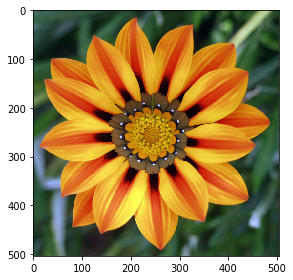

Shape:  (504, 504, 3)


  0%|                                                   | 0/301 [00:00<?, ?it/s]/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat0.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [4, 226]. Convert image to uint8 prior to saving to suppress this warning.


Seps:  0 best_fitness:  1505655216
Saving to  color-tiles/8col/kwiat0.jpg


  3%|█▍                                        | 10/301 [01:10<31:22,  6.47s/it]

Seps:  10 best_fitness:  1282044810
Saving to  color-tiles/8col/kwiat10.jpg


/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat10.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [17, 251]. Convert image to uint8 prior to saving to suppress this warning.
  7%|██▊                                       | 20/301 [02:16<30:56,  6.61s/it]

Seps:  20 best_fitness:  1160240038
Saving to  color-tiles/8col/kwiat20.jpg


/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat20.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [11, 213]. Convert image to uint8 prior to saving to suppress this warning.
 10%|████▏                                     | 30/301 [03:25<30:53,  6.84s/it]/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat30.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [14, 218]. Convert image to uint8 prior to saving to suppress this warning.
 10%|████▎                                     | 31/301 [03:32<31:21,  6.97s/it]

Seps:  30 best_fitness:  1120229802
Saving to  color-tiles/8col/kwiat30.jpg


 13%|█████▌                                    | 40/301 [04:31<29:24,  6.76s/it]/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat40.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [14, 218]. Convert image to uint8 prior to saving to suppress this warning.
 14%|█████▋                                    | 41/301 [04:38<29:18,  6.76s/it]

Seps:  40 best_fitness:  1109076358
Saving to  color-tiles/8col/kwiat40.jpg


 17%|██████▉                                   | 50/301 [05:38<27:56,  6.68s/it]/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat50.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [14, 245]. Convert image to uint8 prior to saving to suppress this warning.


Seps:  50 best_fitness:  1105846192
Saving to  color-tiles/8col/kwiat50.jpg


 20%|████████▎                                 | 60/301 [06:38<23:08,  5.76s/it]/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat60.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [14, 245]. Convert image to uint8 prior to saving to suppress this warning.
 20%|████████▌                                 | 61/301 [06:45<23:45,  5.94s/it]

Seps:  60 best_fitness:  1099756934
Saving to  color-tiles/8col/kwiat60.jpg


 23%|█████████▊                                | 70/301 [07:39<23:46,  6.18s/it]/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat70.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [14, 245]. Convert image to uint8 prior to saving to suppress this warning.
 24%|█████████▉                                | 71/301 [07:46<23:57,  6.25s/it]

Seps:  70 best_fitness:  1083337636
Saving to  color-tiles/8col/kwiat70.jpg


 27%|███████████▏                              | 80/301 [08:39<21:14,  5.77s/it]/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat80.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [20, 245]. Convert image to uint8 prior to saving to suppress this warning.
 27%|███████████▎                              | 81/301 [08:45<21:33,  5.88s/it]

Seps:  80 best_fitness:  1075637488
Saving to  color-tiles/8col/kwiat80.jpg


 30%|████████████▌                             | 90/301 [09:39<21:20,  6.07s/it]

Seps:  90 best_fitness:  1069076376
Saving to  color-tiles/8col/kwiat90.jpg


/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat90.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [20, 245]. Convert image to uint8 prior to saving to suppress this warning.
 33%|█████████████▌                           | 100/301 [10:37<19:42,  5.88s/it]/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat100.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [20, 244]. Convert image to uint8 prior to saving to suppress this warning.
 34%|█████████████▊                           | 101/301 [10:43<19:46,  5.93s/it]

Seps:  100 best_fitness:  1066656198
Saving to  color-tiles/8col/kwiat100.jpg


 37%|██████████████▉                          | 110/301 [11:35<18:29,  5.81s/it]/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat110.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [20, 240]. Convert image to uint8 prior to saving to suppress this warning.
 37%|███████████████                          | 111/301 [11:41<18:35,  5.87s/it]

Seps:  110 best_fitness:  1063532228
Saving to  color-tiles/8col/kwiat110.jpg


 40%|████████████████▎                        | 120/301 [12:32<17:01,  5.64s/it]/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat120.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [20, 240]. Convert image to uint8 prior to saving to suppress this warning.


Seps:  120 best_fitness:  1062359300
Saving to  color-tiles/8col/kwiat120.jpg


 43%|█████████████████▋                       | 130/301 [13:31<15:52,  5.57s/it]/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat130.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [23, 240]. Convert image to uint8 prior to saving to suppress this warning.
 44%|█████████████████▊                       | 131/301 [13:37<16:02,  5.66s/it]

Seps:  130 best_fitness:  1060905508
Saving to  color-tiles/8col/kwiat130.jpg


 47%|███████████████████                      | 140/301 [14:30<16:13,  6.05s/it]/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat140.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [23, 234]. Convert image to uint8 prior to saving to suppress this warning.
 47%|███████████████████▏                     | 141/301 [14:35<15:24,  5.78s/it]

Seps:  140 best_fitness:  1059148508
Saving to  color-tiles/8col/kwiat140.jpg


 50%|████████████████████▍                    | 150/301 [15:29<15:11,  6.04s/it]

Seps:  150 best_fitness:  1058225866
Saving to  color-tiles/8col/kwiat150.jpg


/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat150.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [23, 234]. Convert image to uint8 prior to saving to suppress this warning.
 53%|█████████████████████▊                   | 160/301 [16:25<13:30,  5.75s/it]

Seps:  160 best_fitness:  1057402664
Saving to  color-tiles/8col/kwiat160.jpg


/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat160.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [23, 234]. Convert image to uint8 prior to saving to suppress this warning.
 56%|███████████████████████▏                 | 170/301 [17:22<12:49,  5.88s/it]/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat170.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [23, 234]. Convert image to uint8 prior to saving to suppress this warning.
 57%|███████████████████████▎                 | 171/301 [17:28<12:51,  5.94s/it]

Seps:  170 best_fitness:  1056993912
Saving to  color-tiles/8col/kwiat170.jpg


 60%|████████████████████████▌                | 180/301 [18:20<11:39,  5.78s/it]/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat180.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [23, 234]. Convert image to uint8 prior to saving to suppress this warning.
 60%|████████████████████████▋                | 181/301 [18:26<11:45,  5.88s/it]

Seps:  180 best_fitness:  1056699698
Saving to  color-tiles/8col/kwiat180.jpg


 63%|█████████████████████████▉               | 190/301 [19:17<10:24,  5.63s/it]/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat190.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [23, 234]. Convert image to uint8 prior to saving to suppress this warning.
 63%|██████████████████████████               | 191/301 [19:23<10:32,  5.75s/it]

Seps:  190 best_fitness:  1056489470
Saving to  color-tiles/8col/kwiat190.jpg


 66%|███████████████████████████▏             | 200/301 [20:16<09:57,  5.92s/it]/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat200.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [23, 234]. Convert image to uint8 prior to saving to suppress this warning.
 67%|███████████████████████████▍             | 201/301 [20:23<10:00,  6.00s/it]

Seps:  200 best_fitness:  1056325732
Saving to  color-tiles/8col/kwiat200.jpg


 70%|████████████████████████████▌            | 210/301 [21:18<09:40,  6.38s/it]/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat210.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [25, 234]. Convert image to uint8 prior to saving to suppress this warning.
 70%|████████████████████████████▋            | 211/301 [21:25<09:39,  6.44s/it]

Seps:  210 best_fitness:  1055914968
Saving to  color-tiles/8col/kwiat210.jpg


 73%|█████████████████████████████▉           | 220/301 [22:17<08:07,  6.02s/it]/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat220.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [25, 234]. Convert image to uint8 prior to saving to suppress this warning.
 73%|██████████████████████████████           | 221/301 [22:23<08:02,  6.03s/it]

Seps:  220 best_fitness:  1055914968
Saving to  color-tiles/8col/kwiat220.jpg


 76%|███████████████████████████████▎         | 230/301 [23:16<06:47,  5.74s/it]/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat230.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [25, 234]. Convert image to uint8 prior to saving to suppress this warning.
 77%|███████████████████████████████▍         | 231/301 [23:23<06:56,  5.95s/it]

Seps:  230 best_fitness:  1055652860
Saving to  color-tiles/8col/kwiat230.jpg


 80%|████████████████████████████████▋        | 240/301 [24:19<06:14,  6.14s/it]/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat240.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [25, 233]. Convert image to uint8 prior to saving to suppress this warning.
 80%|████████████████████████████████▊        | 241/301 [24:25<06:08,  6.13s/it]

Seps:  240 best_fitness:  1055511404
Saving to  color-tiles/8col/kwiat240.jpg


 83%|██████████████████████████████████       | 250/301 [25:16<04:56,  5.82s/it]/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat250.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [25, 232]. Convert image to uint8 prior to saving to suppress this warning.
 83%|██████████████████████████████████▏      | 251/301 [25:23<04:57,  5.94s/it]

Seps:  250 best_fitness:  1055437124
Saving to  color-tiles/8col/kwiat250.jpg


 86%|███████████████████████████████████▍     | 260/301 [26:14<03:50,  5.62s/it]/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat260.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [25, 232]. Convert image to uint8 prior to saving to suppress this warning.
 87%|███████████████████████████████████▌     | 261/301 [26:20<03:48,  5.71s/it]

Seps:  260 best_fitness:  1055437124
Saving to  color-tiles/8col/kwiat260.jpg


 90%|████████████████████████████████████▊    | 270/301 [27:12<02:51,  5.54s/it]/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat270.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [25, 232]. Convert image to uint8 prior to saving to suppress this warning.
 90%|████████████████████████████████████▉    | 271/301 [27:18<02:50,  5.68s/it]

Seps:  270 best_fitness:  1055396174
Saving to  color-tiles/8col/kwiat270.jpg


 93%|██████████████████████████████████████▏  | 280/301 [28:10<02:03,  5.87s/it]/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat280.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [25, 232]. Convert image to uint8 prior to saving to suppress this warning.
 93%|██████████████████████████████████████▎  | 281/301 [28:15<01:53,  5.67s/it]

Seps:  280 best_fitness:  1055364352
Saving to  color-tiles/8col/kwiat280.jpg


 96%|███████████████████████████████████████▌ | 290/301 [29:06<01:02,  5.67s/it]/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat290.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [25, 232]. Convert image to uint8 prior to saving to suppress this warning.
 97%|███████████████████████████████████████▋ | 291/301 [29:11<00:55,  5.58s/it]

Seps:  290 best_fitness:  1055364352
Saving to  color-tiles/8col/kwiat290.jpg


100%|████████████████████████████████████████▊| 300/301 [30:03<00:05,  5.71s/it]/tmp/ipykernel_1935032/3482741245.py:57: UserWarning: color-tiles/8col/kwiat300.jpg is a low contrast image
  io.imsave(cur_path, pic)
Lossy conversion from int64 to uint8. Range [25, 232]. Convert image to uint8 prior to saving to suppress this warning.
100%|█████████████████████████████████████████| 301/301 [30:08<00:00,  6.01s/it]

Seps:  300 best_fitness:  1055353420
Saving to  color-tiles/8col/kwiat300.jpg


array([1.50565522e+09, 1.44488466e+09, 1.44488466e+09, 1.44488466e+09,
       1.39560839e+09, 1.39560839e+09, 1.29589481e+09, 1.29589481e+09,
       1.29589481e+09, 1.28204481e+09, 1.28204481e+09, 1.21858330e+09,
       1.21858330e+09, 1.20496297e+09, 1.20496297e+09, 1.20496297e+09,
       1.20074699e+09, 1.19356782e+09, 1.16275425e+09, 1.16275425e+09,
       1.16024004e+09, 1.16024004e+09, 1.16024004e+09, 1.16024004e+09,
       1.15957279e+09, 1.15197487e+09, 1.14474962e+09, 1.14474962e+09,
       1.14462734e+09, 1.13872216e+09, 1.12022980e+09, 1.12022980e+09,
       1.12022980e+09, 1.12022980e+09, 1.12022980e+09, 1.12022980e+09,
       1.12022980e+09, 1.12022980e+09, 1.11768469e+09, 1.10907636e+09,
       1.10907636e+09, 1.10907636e+09, 1.10907636e+09, 1.10907636e+09,
       1.10684066e+09, 1.10631894e+09, 1.10584619e+09, 1.10584619e+09,
       1.10584619e+09, 1.10584619e+09, 1.10584619e+09, 1.10584619e+09,
       1.10584619e+09, 1.10584619e+09, 1.10411314e+09, 1.10371200e+09,
      

In [13]:
cur_target = get_target_picture('flower_medium.jpg')
run_ES(target_pic = cur_target, save_pic = 10, save_path = 'color-tiles/8col/kwiat', number_of_tiles = 8, tile_size = 28, th1 = TH8[1], th2 = TH8[2], th3 = TH8[3], rg1 = RG8[1], rg2 = RG8[2], rg3 = RG8[3])

In [14]:
data = make_tests(tests = 5, target = cur_target, _number_of_tiles = 8, _tile_size = 28, _th1 = TH8[1], _th2 = TH8[2], _th3 = TH8[3], _rg1 = RG8[1], _rg2 = RG8[2], _rg3 = RG8[3])

Test  1


100%|█████████████████████████████████████████| 301/301 [29:01<00:00,  5.79s/it]


Test  2


100%|█████████████████████████████████████████| 301/301 [23:07<00:00,  4.61s/it]


Test  3


100%|█████████████████████████████████████████| 301/301 [20:14<00:00,  4.03s/it]


Test  4


100%|█████████████████████████████████████████| 301/301 [19:39<00:00,  3.92s/it]


Test  5


100%|█████████████████████████████████████████| 301/301 [20:16<00:00,  4.04s/it]


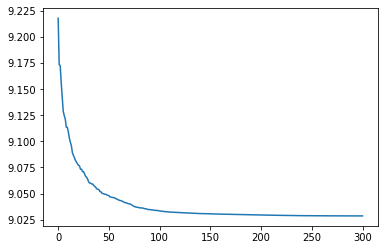

In [15]:
plt.figure()
plt.plot(np.log10(data))
plt.show()

In [16]:
file_to_save = open("color-tiles/8col/col8kwiat.txt", "w")
np.savetxt(file_to_save, data)
file_to_save.close()